In [1]:
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import sem


### Exclusion Criteria
 - Accuracy: 70 % (17/24 correct)
 - RT: Exclude trial if < 250 ms or > 2s
 - Remove participant if more than 10% of the data is removed (?) 
    

### Pilot Analysis Plots

1. Overall Accuracy
    - accuracy by scene category
    - accuracy by zoom 
    - accuracy by zoom x match
2. RT Distribution
    - RT by scene category
    - RT by zoom 
    - RT by zoom x match
3. 2x3 ANOVA
 

In [2]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    
    exclude = []
    
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                # do NOT include subject IDs that have been flagged 
                subjID = df.subjID.unique()[0]
                if subjID not in exclude:
                    data.append(df)

                
        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
    
    print('Number of participants before cleaning: ', len(input_frame.subjID.unique()))

 
    return input_frame

In [3]:
# data_path = '/Users/prachi/Documents/object_scene_scaling_data/pilot2'

data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/OSS_MTurk/data'

In [4]:
input_data = combineCSVs(data_path)

Number of participants before cleaning:  271


In [5]:
num_trials = 24

In [6]:
def cleanbyPracticeTries(df, num_allowed_tries):
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    prac_too_many_dist = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_practice_tries = cleaned_subj_df.pracTries.unique()[0]
        
        if subj_num_practice_tries > num_allowed_tries:
            prac_too_many_dist.append(subj_num_practice_tries)
            remove.append(subj)
        else:  
            df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
            
    print('Number of participants with more than ' + str(num_allowed_tries) + ' practice tries:', len(remove))
    
    return df2, prac_too_many_dist
    

In [7]:
pracTries_cleaned_data, prac_dist = cleanbyPracticeTries(input_data, 3)

Number of participants with more than 3 practice tries: 9


In [8]:
x = [d for d in prac_dist if d > 5]

len(x), len(prac_dist)

(3, 9)

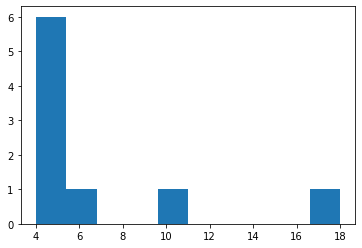

In [9]:
plt.hist(prac_dist)
plt.show()

In [10]:
len(pracTries_cleaned_data.subjID.unique())

262

In [11]:
def Accuracy_Cleaning(df, accuracy_threshold, num_trials):
    """    
    Remove participants with overall accuracy below the accuracy threshold (e.g. 0.7)
    
    Returns:
        data of participants that passed the accuracy threshold 
        list of the number of correct trials each participant got
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    df2_list = []
    list_trials_correct = []
    # number of participants where exclusion is because all responses were 'none'
    c = 0
    
    for subj in all_subjIDs:
        keypresses = []

        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        
        subj_num_correct_trials = 0
        
        acc_column = np.array(list(subj_df['accuracy']))
        sum_acc = np.sum(acc_column)
        
        
        for idx, row in subj_df.iterrows():
            trial_acc = row['accuracy']
            if trial_acc == 1:
                subj_num_correct_trials += 1
            else:
                keypresses.append(row['keyPress'])
        
        subj_acc = sum_acc/num_trials
#         print(acc_column)
#         print(subj, sum_acc, subj_acc)
                
        # minimum number of trials correct the participant must have to be included
        if subj_acc < accuracy_threshold:
#             print(subj_acc, subj)
            remove.append(subj)
#             print(len([x for x in keypresses if x == 'none']))
            if len([x for x in keypresses if x == 'none']) >= 4:
                c += 1
            
#         else:
#             print(subj_acc)
        
        list_trials_correct.append(subj_num_correct_trials)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    
    print("Number of Participants with accuracy below 70%: ", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
                
    print('Number of participants that did not respond for 4 or more trials:', c)
    
    print('Number of participants left: ', len(df2.subjID.unique()))
                
    return df2, list_trials_correct, keypresses

In [12]:
Accuracy_cleaned_data, correct_trials_distribution, keypresses = Accuracy_Cleaning(pracTries_cleaned_data, 0.7, num_trials)


Number of Participants with accuracy below 70%:  26
Number of participants that did not respond for 4 or more trials: 4
Number of participants left:  236


In [13]:
def RT_Cleaning(df, outlier_range, num_trials):
    """
    Remove trials where trial RT is outside of the defined outlier range 
    
    Returns:
        dataframe with outlier RT trials removed
        list of all RTs 
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    print(len(all_subjIDs))
    
    remove = []
    df2_list = []
    total_RT_outliers = 0
    total = 0
    list_trialRT = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 

        for idx, row in subj_df.iterrows():
            total += 1
            RT = row["RT"]
            list_trialRT.append(RT)
            if RT < outlier_range[0]: # outlier
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
                total_RT_outliers += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print(len(df2.subjID.unique()))
                
    return df2, list_trialRT

In [14]:
RT_cleaned_data, trialRTs_distribution = RT_Cleaning(Accuracy_cleaned_data, [250, 5000], num_trials)


236
236


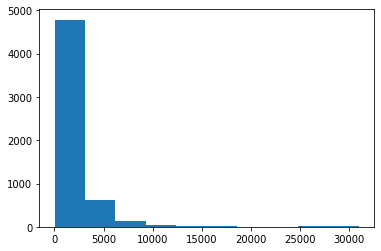

In [15]:
plt.hist(trialRTs_distribution)
plt.show()

In [16]:
all_subjIDs = RT_cleaned_data.subjID.unique()
dist = []
for subj in all_subjIDs:
    count = 0
    subj_df = RT_cleaned_data.loc[RT_cleaned_data['subjID'] == subj]
    dist.append(len(subj_df))
#     print(len(subj_df))

In [17]:
len([d for d in dist if d >11])

228

In [18]:
# pracTries_cleaned_data.subjID.unique(), RT_cleaned_data.subjID.unique()

In [19]:
def finalTrialCountCheck(df, num_trials, min_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        if count_trials < min_trials:
            remove.append(subj)
            
#         threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)

#         if count_trials <= threshold_trials_remaining:
#             remove.append(subj)
            
    print("Number of Participants with >= 10% trials removed: ", len(remove))
            
    for subj in remove:
        df.drop(df[df['subjID'] == subj].index, inplace = True) 
                    
    print("Number of participants left: ",len(df.subjID.unique()))
    return df

In [20]:
finalTrialCount_data = finalTrialCountCheck(RT_cleaned_data, num_trials, 22)

Number of Participants with >= 10% trials removed:  45
Number of participants left:  191


In [21]:
raw_final_data = finalTrialCount_data.copy(deep=True)
len(raw_final_data.subjID.unique())

191

In [22]:
def zscored_outcomes(df):
    '''
    z-score depth estimates and RTs:
        for each subj calculate their avg and std 
        zscored = (estim - subj avg)/subj std
    '''
    #List unique values in the df['subjID'] column
    all_subjIDs = df.subjID.unique()
    
    df2_list = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        final_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning 
        # Z-Score RT
        average_RT = subj_df["RT"].mean()
        std_RT = subj_df["RT"].std()
        subj_RTs = np.array(list(subj_df["RT"]))
        zscored_subj_RTs = (subj_RTs - average_RT)/std_RT
        final_subj_df.insert(4, 'Z-Scored RT',zscored_subj_RTs)
        df2_list.append(final_subj_df)
    
    df2 = pd.concat(df2_list)    

    return df2

In [23]:
zs_final_data = zscored_outcomes(raw_final_data)

In [24]:
final_data = zs_final_data.copy(deep=True)

In [25]:
def add_image_col(df):
    """
    """
    image_col = []
    
    for idx, row in df.iterrows():
        image_col.append(row['image'][:-6])

    
    return np.array(image_col)

In [26]:
image_column = add_image_col(final_data)

# # add misscaled column to dataframe 
final_data.insert(14, "image_name", image_column)


In [27]:
def add_size_col(df):
    """
    """
    big_objects = ['clipboard', 'kettle', 'laptop', 'notebook', 'pot', 'toaster']
    small_objects = ['binderclip', 'eraser', 'flashdrive', 'saltshaker', 'sponge', 'spoon']
    
    size_col = []
    
    for idx, row in df.iterrows():
        obj = row['object']
        presentationSize = row['presentationSize']
        if obj in big_objects:
            if presentationSize == 'large':
                size_col.append('canonical')
            if presentationSize =='small':
                size_col.append('tooSmall')
        if obj in small_objects:
            if presentationSize == 'large':
                size_col.append('tooBig')
            if presentationSize =='small':
                size_col.append('canonical')
                
        size_col.append(row['image'][:-6])

    
    return np.array(size_col)

In [28]:
size_column = add_size_col(final_data)

# # add misscaled column to dataframe 
final_data.insert(14, "size_name", image_column)


In [29]:
final_data.to_csv('zs_e5v2Final_unfolded.csv', index=False)

In [30]:
len(final_data.subjID.unique())

191

In [30]:
# input_data

In [31]:
final_data = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/OSS/zs_e5v2Final_unfolded.csv')

# Analyze Data by Mis-scaling Rating

In [31]:
data_1 = final_data.loc[final_data['rating'] == 1]
data_2 = final_data.loc[final_data['rating'] == 2]
data_3 = final_data.loc[final_data['rating'] == 3]
data_4 = final_data.loc[final_data['rating'] == 4]


data_5 = final_data.loc[final_data['rating'] == 5]
data_6 = final_data.loc[final_data['rating'] == 6]
data_7 = final_data.loc[final_data['rating'] == 7]

In [32]:
len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy']), len(data_5['accuracy']), len(data_6['accuracy']), len(data_7['accuracy'])


(244, 167, 166, 697, 292, 244, 455)

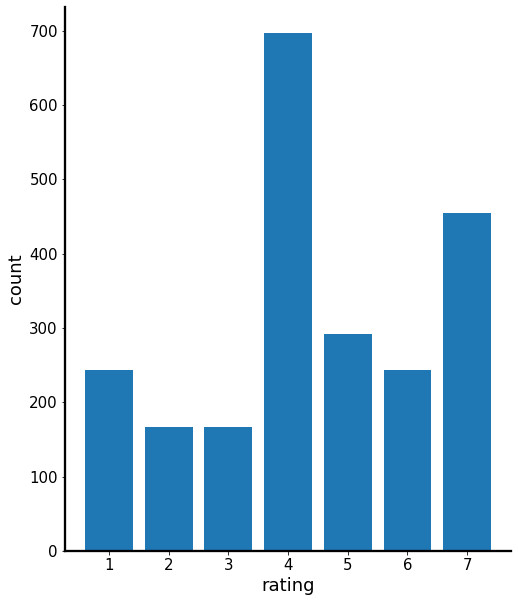

In [33]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)
    
plt.bar(['1', '2', '3', '4', '5', '6', '7'], [len(data_1['accuracy']), len(data_2['accuracy']), len(data_3['accuracy']), len(data_4['accuracy']), len(data_5['accuracy']), len(data_6['accuracy']), len(data_7['accuracy'])
])
plt.show()

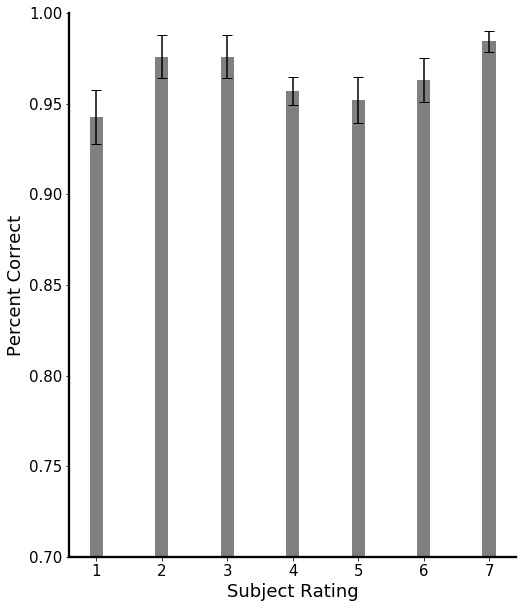

In [34]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

Acc_ =   [np.sum(np.array(data_1['accuracy']))/len(np.array(data_1['accuracy'])), np.sum(np.array(data_2['accuracy']))/len(np.array(data_2['accuracy'])), np.sum(np.array(data_3['accuracy']))/len(np.array(data_3['accuracy'])), np.sum(np.array(data_4['accuracy']))/len(np.array(data_4['accuracy'])), np.sum(np.array(data_5['accuracy']))/len(np.array(data_5['accuracy'])), np.sum(np.array(data_6['accuracy']))/len(np.array(data_6['accuracy'])), np.sum(np.array(data_7['accuracy']))/len(np.array(data_7['accuracy']))]
yerr_ =  [np.std(np.array(data_1['accuracy']))/np.sqrt(len(np.array(data_1['accuracy']))), np.std(np.array(data_2['accuracy']))/np.sqrt(len(np.array(data_2['accuracy']))), np.std(np.array(data_3['accuracy']))/np.sqrt(len(np.array(data_3['accuracy']))), np.std(np.array(data_4['accuracy']))/np.sqrt(len(np.array(data_4['accuracy']))), np.std(np.array(data_5['accuracy']))/np.sqrt(len(np.array(data_5['accuracy']))), np.std(np.array(data_6['accuracy']))/np.sqrt(len(np.array(data_6['accuracy']))), np.std(np.array(data_7['accuracy']))/np.sqrt(len(np.array(data_7['accuracy'])))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, Acc_, width, color='gray', yerr=yerr_, capsize=5)
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')
plt.ylim(0.70, 1)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

In [35]:
data_1_zo = data_1.loc[data_1['presentationSize'] == 'large']
data_1_zi = data_1.loc[data_1['presentationSize'] == 'small']

data_2_zo = data_2.loc[data_2['presentationSize'] == 'large']
data_2_zi = data_2.loc[data_2['presentationSize'] == 'small']

data_3_zo = data_3.loc[data_3['presentationSize'] == 'large']
data_3_zi = data_3.loc[data_3['presentationSize'] == 'small']

data_4_zo = data_4.loc[data_4['presentationSize'] == 'large']
data_4_zi = data_4.loc[data_4['presentationSize'] == 'small']


data_5_zo = data_5.loc[data_5['presentationSize'] == 'large']
data_5_zi = data_5.loc[data_5['presentationSize'] == 'small']

data_6_zo = data_6.loc[data_6['presentationSize'] == 'large']
data_6_zi = data_6.loc[data_6['presentationSize'] == 'small']

data_7_zo = data_7.loc[data_7['presentationSize'] == 'large']
data_7_zi = data_7.loc[data_7['presentationSize'] == 'small']



In [36]:
# Accuracy

data_1_zo_acc = np.sum(np.array(data_1_zo['accuracy']))/len(np.array(data_1_zo['accuracy']))

data_1_zo_sem = np.std(np.array(data_1_zo['accuracy']))/np.sqrt(len(np.array(data_1_zo['accuracy'])))

print(len(np.array(data_1_zo['accuracy'])))


data_2_zo_acc = np.sum(np.array(data_2_zo['accuracy']))/len(np.array(data_2_zo['accuracy']))

data_2_zo_sem = np.std(np.array(data_2_zo['accuracy']))/np.sqrt(len(np.array(data_2_zo['accuracy'])))

print(len(np.array(data_2_zo['accuracy'])))


data_3_zo_acc = np.sum(np.array(data_3_zo['accuracy']))/len(np.array(data_3_zo['accuracy']))

data_3_zo_sem = np.std(np.array(data_3_zo['accuracy']))/np.sqrt(len(np.array(data_3_zo['accuracy'])))

print(len(np.array(data_3_zo['accuracy'])))

data_4_zo_acc = np.sum(np.array(data_4_zo['accuracy']))/len(np.array(data_4_zo['accuracy']))

data_4_zo_sem = np.std(np.array(data_4_zo['accuracy']))/np.sqrt(len(np.array(data_4_zo['accuracy'])))

print(len(np.array(data_4_zo['accuracy'])))

data_5_zo_acc = np.sum(np.array(data_5_zo['accuracy']))/len(np.array(data_5_zo['accuracy']))

data_5_zo_sem = np.std(np.array(data_5_zo['accuracy']))/np.sqrt(len(np.array(data_5_zo['accuracy'])))

print(len(np.array(data_5_zo['accuracy'])))


data_6_zo_acc = np.sum(np.array(data_6_zo['accuracy']))/len(np.array(data_6_zo['accuracy']))

data_6_zo_sem = np.std(np.array(data_6_zo['accuracy']))/np.sqrt(len(np.array(data_6_zo['accuracy'])))

print(len(np.array(data_6_zo['accuracy'])))

data_7_zo_acc = np.sum(np.array(data_7_zo['accuracy']))/len(np.array(data_7_zo['accuracy']))

data_7_zo_sem = np.std(np.array(data_7_zo['accuracy']))/np.sqrt(len(np.array(data_7_zo['accuracy'])))

print(len(np.array(data_7_zo['accuracy'])))


13
18
40
333
162
160
415


In [37]:
data_1_objectScene1SemanticCongruency0 = data_1.loc[data_1['objSceneSemCong'] == 0]
data_1_objectScene1SemanticCongruency1 = data_1.loc[data_1['objSceneSemCong'] == 1]

data_2_objectScene1SemanticCongruency0 = data_2.loc[data_2['objSceneSemCong'] == 0]
data_2_objectScene1SemanticCongruency1 = data_2.loc[data_2['objSceneSemCong'] == 1]

data_3_objectScene1SemanticCongruency0 = data_3.loc[data_3['objSceneSemCong'] == 0]
data_3_objectScene1SemanticCongruency1 = data_3.loc[data_3['objSceneSemCong'] == 1]

data_4_objectScene1SemanticCongruency0 = data_4.loc[data_4['objSceneSemCong'] == 0]
data_4_objectScene1SemanticCongruency1 = data_4.loc[data_4['objSceneSemCong'] == 1]

data_5_objectScene1SemanticCongruency0 = data_5.loc[data_5['objSceneSemCong'] == 0]
data_5_objectScene1SemanticCongruency1 = data_5.loc[data_5['objSceneSemCong'] == 1]

data_6_objectScene1SemanticCongruency0 = data_6.loc[data_6['objSceneSemCong'] == 0]
data_6_objectScene1SemanticCongruency1 = data_6.loc[data_6['objSceneSemCong'] == 1]

data_7_objectScene1SemanticCongruency0 = data_7.loc[data_7['objSceneSemCong'] == 0]
data_7_objectScene1SemanticCongruency1 = data_7.loc[data_7['objSceneSemCong'] == 1]



In [38]:
# Accuracy

data_1_zo_acc = np.sum(np.array(data_1_zo['accuracy']))/len(np.array(data_1_zo['accuracy']))
data_1_zi_acc =np.sum(np.array(data_1_zi['accuracy']))/len(np.array(data_1_zi['accuracy']))

data_1_zo_sem = np.std(np.array(data_1_zo['accuracy']))/np.sqrt(len(np.array(data_1_zo['accuracy'])))
data_1_zi_sem = np.std(np.array(data_1_zi['accuracy']))/np.sqrt(len(np.array(data_1_zi['accuracy'])))

print(len(np.array(data_1_zo['accuracy'])))
print(len(np.array(data_1_zi['accuracy'])))


data_2_zo_acc = np.sum(np.array(data_2_zo['accuracy']))/len(np.array(data_2_zo['accuracy']))
data_2_zi_acc =np.sum(np.array(data_2_zi['accuracy']))/len(np.array(data_2_zi['accuracy']))

data_2_zo_sem = np.std(np.array(data_2_zo['accuracy']))/np.sqrt(len(np.array(data_2_zo['accuracy'])))
data_2_zi_sem = np.std(np.array(data_2_zi['accuracy']))/np.sqrt(len(np.array(data_2_zi['accuracy'])))

print(len(np.array(data_2_zo['accuracy'])))
print(len(np.array(data_2_zi['accuracy'])))


data_3_zo_acc = np.sum(np.array(data_3_zo['accuracy']))/len(np.array(data_3_zo['accuracy']))
data_3_zi_acc =np.sum(np.array(data_3_zi['accuracy']))/len(np.array(data_3_zi['accuracy']))

data_3_zo_sem = np.std(np.array(data_3_zo['accuracy']))/np.sqrt(len(np.array(data_3_zo['accuracy'])))
data_3_zi_sem = np.std(np.array(data_3_zi['accuracy']))/np.sqrt(len(np.array(data_3_zi['accuracy'])))

print(len(np.array(data_3_zo['accuracy'])))
print(len(np.array(data_3_zi['accuracy'])))

data_4_zo_acc = np.sum(np.array(data_4_zo['accuracy']))/len(np.array(data_4_zo['accuracy']))
data_4_zi_acc =np.sum(np.array(data_4_zi['accuracy']))/len(np.array(data_4_zi['accuracy']))

data_4_zo_sem = np.std(np.array(data_4_zo['accuracy']))/np.sqrt(len(np.array(data_4_zo['accuracy'])))
data_4_zi_sem = np.std(np.array(data_4_zi['accuracy']))/np.sqrt(len(np.array(data_4_zi['accuracy'])))

print(len(np.array(data_4_zo['accuracy'])))
print(len(np.array(data_4_zi['accuracy'])))

data_5_zo_acc = np.sum(np.array(data_5_zo['accuracy']))/len(np.array(data_5_zo['accuracy']))
data_5_zi_acc =np.sum(np.array(data_5_zi['accuracy']))/len(np.array(data_5_zi['accuracy']))

data_5_zo_sem = np.std(np.array(data_5_zo['accuracy']))/np.sqrt(len(np.array(data_5_zo['accuracy'])))
data_5_zi_sem = np.std(np.array(data_5_zi['accuracy']))/np.sqrt(len(np.array(data_5_zi['accuracy'])))

print(len(np.array(data_5_zo['accuracy'])))
print(len(np.array(data_5_zi['accuracy'])))


data_6_zo_acc = np.sum(np.array(data_6_zo['accuracy']))/len(np.array(data_6_zo['accuracy']))
data_6_zi_acc =np.sum(np.array(data_6_zi['accuracy']))/len(np.array(data_6_zi['accuracy']))

data_6_zo_sem = np.std(np.array(data_6_zo['accuracy']))/np.sqrt(len(np.array(data_6_zo['accuracy'])))
data_6_zi_sem = np.std(np.array(data_6_zi['accuracy']))/np.sqrt(len(np.array(data_6_zi['accuracy'])))

print(len(np.array(data_6_zo['accuracy'])))
print(len(np.array(data_6_zi['accuracy'])))

data_7_zo_acc = np.sum(np.array(data_7_zo['accuracy']))/len(np.array(data_7_zo['accuracy']))
data_7_zi_acc =np.sum(np.array(data_7_zi['accuracy']))/len(np.array(data_7_zi['accuracy']))

data_7_zo_sem = np.std(np.array(data_7_zo['accuracy']))/np.sqrt(len(np.array(data_7_zo['accuracy'])))
data_7_zi_sem = np.std(np.array(data_7_zi['accuracy']))/np.sqrt(len(np.array(data_7_zi['accuracy'])))

print(len(np.array(data_7_zo['accuracy'])))
print(len(np.array(data_7_zi['accuracy'])))


13
231
18
149
40
126
333
364
162
130
160
84
415
40


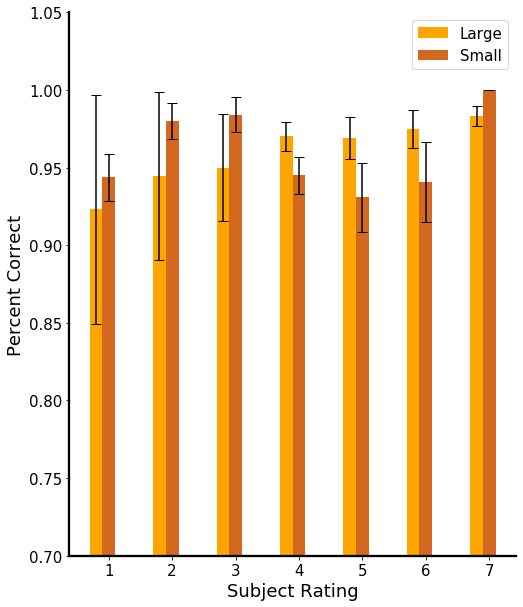

In [39]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

Acc_zo =   [data_1_zo_acc, data_2_zo_acc, data_3_zo_acc, data_4_zo_acc, data_5_zo_acc, data_6_zo_acc, data_7_zo_acc]
yerr_zo =  [data_1_zo_sem, data_2_zo_sem, data_3_zo_sem, data_4_zo_sem, data_5_zo_sem, data_6_zo_sem, data_7_zo_sem]

Acc_zi =   [data_1_zi_acc, data_2_zi_acc, data_3_zi_acc, data_4_zi_acc, data_5_zi_acc, data_6_zi_acc, data_7_zi_acc]
yerr_zi =  [data_1_zi_sem, data_2_zi_sem, data_3_zi_sem, data_4_zi_sem, data_5_zi_sem, data_6_zi_sem, data_7_zi_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_zo, width, color='orange', label='Large', yerr=yerr_zo, capsize=5)
plt.bar(x, Acc_zi, width, color='chocolate', label='Small', yerr=yerr_zi, capsize=5)
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')
plt.ylim(0.70)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [40]:
data_1_objectScene1SemanticCongruency0 = data_1.loc[data_1['objSceneSemCong'] == 0]
data_1_objectScene1SemanticCongruency1 = data_1.loc[data_1['objSceneSemCong'] == 1]

data_2_objectScene1SemanticCongruency0 = data_2.loc[data_2['objSceneSemCong'] == 0]
data_2_objectScene1SemanticCongruency1 = data_2.loc[data_2['objSceneSemCong'] == 1]

data_3_objectScene1SemanticCongruency0 = data_3.loc[data_3['objSceneSemCong'] == 0]
data_3_objectScene1SemanticCongruency1 = data_3.loc[data_3['objSceneSemCong'] == 1]

data_4_objectScene1SemanticCongruency0 = data_4.loc[data_4['objSceneSemCong'] == 0]
data_4_objectScene1SemanticCongruency1 = data_4.loc[data_4['objSceneSemCong'] == 1]

data_5_objectScene1SemanticCongruency0 = data_5.loc[data_5['objSceneSemCong'] == 0]
data_5_objectScene1SemanticCongruency1 = data_5.loc[data_5['objSceneSemCong'] == 1]

data_6_objectScene1SemanticCongruency0 = data_6.loc[data_6['objSceneSemCong'] == 0]
data_6_objectScene1SemanticCongruency1 = data_6.loc[data_6['objSceneSemCong'] == 1]

data_7_objectScene1SemanticCongruency0 = data_7.loc[data_7['objSceneSemCong'] == 0]
data_7_objectScene1SemanticCongruency1 = data_7.loc[data_7['objSceneSemCong'] == 1]

In [41]:
# Accuracy

data_1_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))
data_1_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))

data_1_objectScene1SemanticCongruency0_sem = np.std(np.array(data_1_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))
data_1_objectScene1SemanticCongruency1_sem = np.std(np.array(data_1_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_1_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_1_objectScene1SemanticCongruency0['accuracy'])))

data_2_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))
data_2_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))

data_2_objectScene1SemanticCongruency0_sem = np.std(np.array(data_2_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))
data_2_objectScene1SemanticCongruency1_sem = np.std(np.array(data_2_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_2_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_2_objectScene1SemanticCongruency0['accuracy'])))

data_3_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))
data_3_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))

data_3_objectScene1SemanticCongruency0_sem = np.std(np.array(data_3_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))
data_3_objectScene1SemanticCongruency1_sem = np.std(np.array(data_3_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_3_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_3_objectScene1SemanticCongruency0['accuracy'])))

data_4_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))
data_4_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))

data_4_objectScene1SemanticCongruency0_sem = np.std(np.array(data_4_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))
data_4_objectScene1SemanticCongruency1_sem = np.std(np.array(data_4_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_4_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_4_objectScene1SemanticCongruency0['accuracy'])))

data_5_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_5_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_5_objectScene1SemanticCongruency0['accuracy']))
data_5_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_5_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_5_objectScene1SemanticCongruency1['accuracy']))

data_5_objectScene1SemanticCongruency0_sem = np.std(np.array(data_5_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_5_objectScene1SemanticCongruency0['accuracy'])))
data_5_objectScene1SemanticCongruency1_sem = np.std(np.array(data_5_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_5_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_5_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_5_objectScene1SemanticCongruency0['accuracy'])))

data_6_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_6_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_6_objectScene1SemanticCongruency0['accuracy']))
data_6_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_6_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_6_objectScene1SemanticCongruency1['accuracy']))

data_6_objectScene1SemanticCongruency0_sem = np.std(np.array(data_6_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_6_objectScene1SemanticCongruency0['accuracy'])))
data_6_objectScene1SemanticCongruency1_sem = np.std(np.array(data_6_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_6_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_6_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_6_objectScene1SemanticCongruency0['accuracy'])))

data_7_objectScene1SemanticCongruency0_acc = np.sum(np.array(data_7_objectScene1SemanticCongruency0['accuracy']))/len(np.array(data_7_objectScene1SemanticCongruency0['accuracy']))
data_7_objectScene1SemanticCongruency1_acc =np.sum(np.array(data_7_objectScene1SemanticCongruency1['accuracy']))/len(np.array(data_7_objectScene1SemanticCongruency1['accuracy']))

data_7_objectScene1SemanticCongruency0_sem = np.std(np.array(data_7_objectScene1SemanticCongruency0['accuracy']))/np.sqrt(len(np.array(data_7_objectScene1SemanticCongruency0['accuracy'])))
data_7_objectScene1SemanticCongruency1_sem = np.std(np.array(data_7_objectScene1SemanticCongruency1['accuracy']))/np.sqrt(len(np.array(data_7_objectScene1SemanticCongruency1['accuracy'])))

print(len(np.array(data_7_objectScene1SemanticCongruency0['accuracy'])) + len(np.array(data_7_objectScene1SemanticCongruency0['accuracy'])))



234
176
174
712
294
234
448


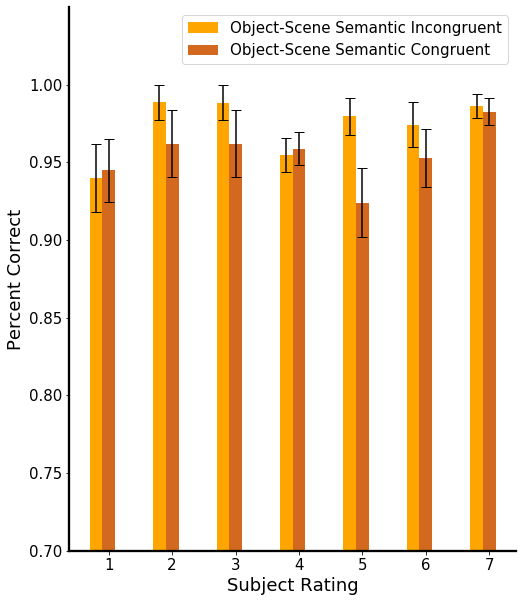

In [42]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

Acc_0 =   [data_1_objectScene1SemanticCongruency0_acc, data_2_objectScene1SemanticCongruency0_acc, data_3_objectScene1SemanticCongruency0_acc, data_4_objectScene1SemanticCongruency0_acc, data_5_objectScene1SemanticCongruency0_acc, data_6_objectScene1SemanticCongruency0_acc, data_7_objectScene1SemanticCongruency0_acc]
yerr_0 =  [data_1_objectScene1SemanticCongruency0_sem, data_2_objectScene1SemanticCongruency0_sem, data_3_objectScene1SemanticCongruency0_sem, data_4_objectScene1SemanticCongruency0_sem, data_5_objectScene1SemanticCongruency0_sem, data_6_objectScene1SemanticCongruency0_sem, data_7_objectScene1SemanticCongruency0_sem]

Acc_1 =   [data_1_objectScene1SemanticCongruency1_acc, data_2_objectScene1SemanticCongruency1_acc, data_3_objectScene1SemanticCongruency1_acc, data_4_objectScene1SemanticCongruency1_acc, data_5_objectScene1SemanticCongruency1_acc, data_6_objectScene1SemanticCongruency1_acc, data_7_objectScene1SemanticCongruency1_acc]
yerr_1 =  [data_1_objectScene1SemanticCongruency1_sem, data_2_objectScene1SemanticCongruency1_sem, data_3_objectScene1SemanticCongruency1_sem, data_4_objectScene1SemanticCongruency1_sem, data_5_objectScene1SemanticCongruency1_sem, data_6_objectScene1SemanticCongruency1_sem, data_7_objectScene1SemanticCongruency1_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, Acc_0, width, color='orange', label='Object-Scene Semantic Incongruent', yerr=yerr_0, capsize=5)
plt.bar(x, Acc_1, width, color='chocolate', label='Object-Scene Semantic Congruent', yerr=yerr_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')
plt.ylim(0.7)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Percent Correct", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [43]:
final_data_correctOnly = final_data.loc[final_data['accuracy']==1]


In [44]:
data_1_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 1]
data_2_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 2]
data_3_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 3]
data_4_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 4]

data_1_zo_CO = data_1_CO.loc[data_1_CO['presentationSize'] == 'large']
data_1_zi_CO = data_1_CO.loc[data_1_CO['presentationSize'] == 'small']

data_2_zo_CO = data_2_CO.loc[data_2_CO['presentationSize'] == 'large']
data_2_zi_CO = data_2_CO.loc[data_2_CO['presentationSize'] == 'small']

data_3_zo_CO = data_3_CO.loc[data_3_CO['presentationSize'] == 'large']
data_3_zi_CO = data_3_CO.loc[data_3_CO['presentationSize'] == 'small']

data_4_zo_CO = data_4_CO.loc[data_4_CO['presentationSize'] == 'large']
data_4_zi_CO = data_4_CO.loc[data_4_CO['presentationSize'] == 'small']



data_5_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 5]
data_6_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 6]
data_7_CO = final_data_correctOnly.loc[final_data_correctOnly['rating'] == 7]

data_5_zo_CO = data_5_CO.loc[data_5_CO['presentationSize'] == 'large']
data_5_zi_CO = data_5_CO.loc[data_5_CO['presentationSize'] == 'small']

data_6_zo_CO = data_6_CO.loc[data_6_CO['presentationSize'] == 'large']
data_6_zi_CO = data_6_CO.loc[data_6_CO['presentationSize'] == 'small']

data_7_zo_CO = data_7_CO.loc[data_7_CO['presentationSize'] == 'large']
data_7_zi_CO = data_7_CO.loc[data_7_CO['presentationSize'] == 'small']


In [45]:
# RT 
data_1_zo_RT = np.mean(np.array(data_1_zo_CO['RT']))
data_1_zi_RT = np.mean(np.array(data_1_zi_CO['RT']))

data_1_zo_RT_sem = sem(np.array(data_1_zo_CO['RT']))
data_1_zi_RT_sem = sem(np.array(data_1_zi_CO['RT']))


data_2_zo_RT = np.mean(np.array(data_2_zo_CO['RT']))
data_2_zi_RT = np.mean(np.array(data_2_zi_CO['RT']))

data_2_zo_RT_sem = sem(np.array(data_2_zo_CO['RT']))
data_2_zi_RT_sem = sem(np.array(data_2_zi_CO['RT']))


data_3_zo_RT = np.mean(np.array(data_3_zo_CO['RT']))
data_3_zi_RT = np.mean(np.array(data_3_zi_CO['RT']))

data_3_zo_RT_sem = sem(np.array(data_3_zo_CO['RT']))
data_3_zi_RT_sem =sem(np.array(data_3_zi_CO['RT']))


data_4_zo_RT = np.mean(np.array(data_4_zo_CO['RT']))
data_4_zi_RT = np.mean(np.array(data_4_zi_CO['RT']))

data_4_zo_RT_sem = sem(np.array(data_4_zo_CO['RT']))
data_4_zi_RT_sem = sem(np.array(data_4_zi_CO['RT']))

data_5_zo_RT = np.mean(np.array(data_5_zo_CO['RT']))
data_5_zi_RT = np.mean(np.array(data_5_zi_CO['RT']))

data_5_zo_RT_sem = sem(np.array(data_5_zo_CO['RT']))
data_5_zi_RT_sem = sem(np.array(data_5_zi_CO['RT']))


data_6_zo_RT = np.mean(np.array(data_6_zo_CO['RT']))
data_6_zi_RT = np.mean(np.array(data_6_zi_CO['RT']))

data_6_zo_RT_sem = sem(np.array(data_6_zo_CO['RT']))
data_6_zi_RT_sem = sem(np.array(data_6_zi_CO['RT']))


data_7_zo_RT = np.mean(np.array(data_7_zo_CO['RT']))
data_7_zi_RT = np.mean(np.array(data_7_zi_CO['RT']))

data_7_zo_RT_sem = sem(np.array(data_7_zo_CO['RT']))
data_7_zi_RT_sem = sem(np.array(data_7_zi_CO['RT']))



In [46]:
len(data_1_CO['accuracy']), len(data_2_CO['accuracy']), len(data_3_CO['accuracy']), len(data_4_CO['accuracy']), len(data_5_CO['accuracy']), len(data_6_CO['accuracy']), len(data_7_CO['accuracy'])



(230, 163, 162, 667, 278, 235, 448)

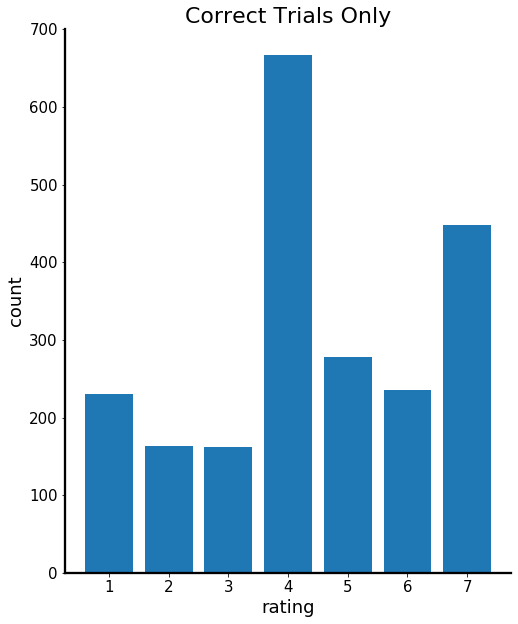

In [47]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
plt.xticks( fontsize='15')
plt.yticks(fontsize=15) 
plt.ylabel('count', fontsize=18)
plt.xlabel('rating', fontsize=18)

plt.title('Correct Trials Only', fontsize=22)
    
plt.bar(['1', '2', '3', '4', '5', '6', '7'], [len(data_1_CO['accuracy']), len(data_2_CO['accuracy']), len(data_3_CO['accuracy']), len(data_4_CO['accuracy']), len(data_5_CO['accuracy']), len(data_6_CO['accuracy']), len(data_7_CO['accuracy'])
])

plt.show()

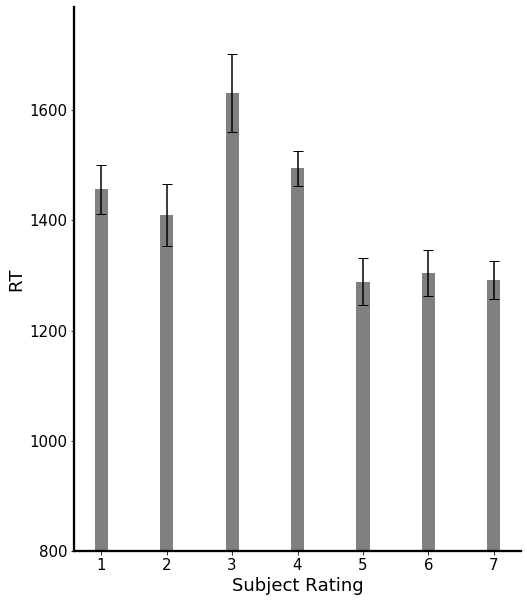

In [48]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

RT_ = [np.mean(np.array(data_1_CO['RT'])), np.mean(np.array(data_2_CO['RT'])), np.mean(np.array(data_3_CO['RT'])), np.mean(np.array(data_4_CO['RT'])), np.mean(np.array(data_5_CO['RT'])), np.mean(np.array(data_6_CO['RT'])), np.mean(np.array(data_7_CO['RT']))]
yerr_RT = [sem(np.array(data_1_CO['RT'])), sem(np.array(data_2_CO['RT'])), sem(np.array(data_3_CO['RT'])), sem(np.array(data_4_CO['RT'])), sem(np.array(data_5_CO['RT'])), sem(np.array(data_6_CO['RT'])), sem(np.array(data_7_CO['RT']))]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x, RT_, width, color='gray', yerr=yerr_RT, capsize=5)
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')
plt.ylim(800)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT", fontsize=18)
# plt.legend(loc=1, fontsize=15)
plt.show()

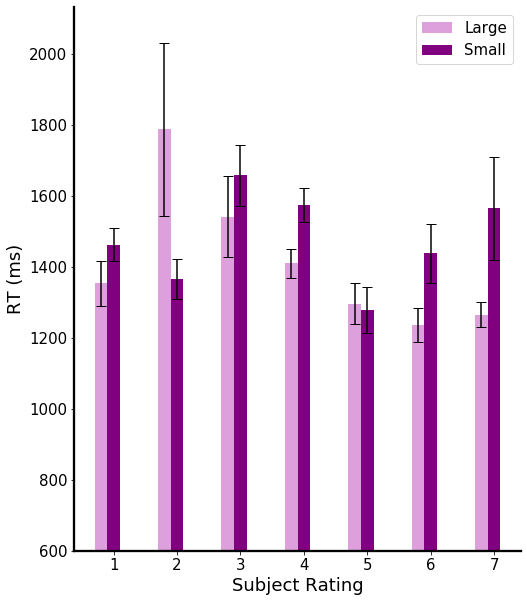

In [49]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

RT_zo =   [data_1_zo_RT, data_2_zo_RT, data_3_zo_RT, data_4_zo_RT, data_5_zo_RT, data_6_zo_RT, data_7_zo_RT]
yerr_RT_zo =  [data_1_zo_RT_sem, data_2_zo_RT_sem, data_3_zo_RT_sem, data_4_zo_RT_sem, data_5_zo_RT_sem, data_6_zo_RT_sem, data_7_zo_RT_sem]

RT_zi =   [data_1_zi_RT, data_2_zi_RT, data_3_zi_RT, data_4_zi_RT, data_5_zi_RT, data_6_zi_RT, data_7_zi_RT]
yerr_RT_zi =  [data_1_zi_RT_sem, data_2_zi_RT_sem, data_3_zi_RT_sem, data_4_zi_RT_sem, data_5_zi_RT_sem, data_6_zi_RT_sem, data_7_zi_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_zo, width, color='plum', label='Large', yerr=yerr_RT_zo, capsize=5)
plt.bar(x, RT_zi, width, color='purple', label='Small', yerr=yerr_RT_zi, capsize=5)
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')
plt.ylim(600)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT (ms)", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [50]:
data_1_objectScene1SemanticCongruency0_CO = data_1_CO.loc[data_1_CO['objSceneSemCong'] == 0]
data_1_objectScene1SemanticCongruency1_CO = data_1_CO.loc[data_1_CO['objSceneSemCong'] == 1]

data_2_objectScene1SemanticCongruency0_CO = data_2_CO.loc[data_2_CO['objSceneSemCong'] == 0]
data_2_objectScene1SemanticCongruency1_CO = data_2_CO.loc[data_2_CO['objSceneSemCong'] == 1]

data_3_objectScene1SemanticCongruency0_CO = data_3_CO.loc[data_3_CO['objSceneSemCong'] == 0]
data_3_objectScene1SemanticCongruency1_CO = data_3_CO.loc[data_3_CO['objSceneSemCong'] == 1]

data_4_objectScene1SemanticCongruency0_CO = data_4_CO.loc[data_4_CO['objSceneSemCong'] == 0]
data_4_objectScene1SemanticCongruency1_CO = data_4_CO.loc[data_4_CO['objSceneSemCong'] == 1]

data_5_objectScene1SemanticCongruency0_CO = data_5_CO.loc[data_5_CO['objSceneSemCong'] == 0]
data_5_objectScene1SemanticCongruency1_CO = data_5_CO.loc[data_5_CO['objSceneSemCong'] == 1]

data_6_objectScene1SemanticCongruency0_CO = data_6_CO.loc[data_6_CO['objSceneSemCong'] == 0]
data_6_objectScene1SemanticCongruency1_CO = data_6_CO.loc[data_6_CO['objSceneSemCong'] == 1]

data_7_objectScene1SemanticCongruency0_CO = data_7_CO.loc[data_7_CO['objSceneSemCong'] == 0]
data_7_objectScene1SemanticCongruency1_CO = data_7_CO.loc[data_7_CO['objSceneSemCong'] == 1]


In [51]:
data_1_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))

data_1_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency0_CO['RT']))
data_1_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_1_objectScene1SemanticCongruency1_CO['RT']))


data_2_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))

data_2_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency0_CO['RT']))
data_2_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_2_objectScene1SemanticCongruency1_CO['RT']))


data_3_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))

data_3_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_3_objectScene1SemanticCongruency0_CO['RT']))
data_3_objectScene1SemanticCongruency1_CO_RT_sem =sem(np.array(data_3_objectScene1SemanticCongruency1_CO['RT']))


data_4_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))

data_4_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency0_CO['RT']))
data_4_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_4_objectScene1SemanticCongruency1_CO['RT']))


data_5_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_5_objectScene1SemanticCongruency0_CO['RT']))
data_5_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_5_objectScene1SemanticCongruency1_CO['RT']))

data_5_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_5_objectScene1SemanticCongruency0_CO['RT']))
data_5_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_5_objectScene1SemanticCongruency1_CO['RT']))


data_6_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_6_objectScene1SemanticCongruency0_CO['RT']))
data_6_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_6_objectScene1SemanticCongruency1_CO['RT']))

data_6_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_6_objectScene1SemanticCongruency0_CO['RT']))
data_6_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_6_objectScene1SemanticCongruency1_CO['RT']))


data_7_objectScene1SemanticCongruency0_CO_RT = np.mean(np.array(data_7_objectScene1SemanticCongruency0_CO['RT']))
data_7_objectScene1SemanticCongruency1_CO_RT = np.mean(np.array(data_7_objectScene1SemanticCongruency1_CO['RT']))

data_7_objectScene1SemanticCongruency0_CO_RT_sem = sem(np.array(data_7_objectScene1SemanticCongruency0_CO['RT']))
data_7_objectScene1SemanticCongruency1_CO_RT_sem = sem(np.array(data_7_objectScene1SemanticCongruency1_CO['RT']))

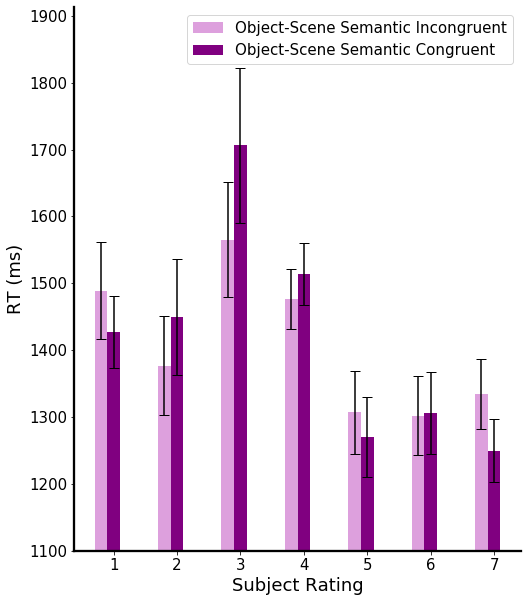

In [52]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

RT_0 =   [data_1_objectScene1SemanticCongruency0_CO_RT, data_2_objectScene1SemanticCongruency0_CO_RT, data_3_objectScene1SemanticCongruency0_CO_RT, data_4_objectScene1SemanticCongruency0_CO_RT, data_5_objectScene1SemanticCongruency0_CO_RT, data_6_objectScene1SemanticCongruency0_CO_RT, data_7_objectScene1SemanticCongruency0_CO_RT]
yerr_RT_0 =  [data_1_objectScene1SemanticCongruency0_CO_RT_sem, data_2_objectScene1SemanticCongruency0_CO_RT_sem, data_3_objectScene1SemanticCongruency0_CO_RT_sem, data_4_objectScene1SemanticCongruency0_CO_RT_sem, data_5_objectScene1SemanticCongruency0_CO_RT_sem, data_6_objectScene1SemanticCongruency0_CO_RT_sem, data_7_objectScene1SemanticCongruency0_CO_RT_sem]

RT_1 =   [data_1_objectScene1SemanticCongruency1_CO_RT, data_2_objectScene1SemanticCongruency1_CO_RT, data_3_objectScene1SemanticCongruency1_CO_RT, data_4_objectScene1SemanticCongruency1_CO_RT, data_5_objectScene1SemanticCongruency1_CO_RT, data_6_objectScene1SemanticCongruency1_CO_RT, data_7_objectScene1SemanticCongruency1_CO_RT]
yerr_RT_1 =  [data_1_objectScene1SemanticCongruency1_CO_RT_sem, data_2_objectScene1SemanticCongruency1_CO_RT_sem, data_3_objectScene1SemanticCongruency1_CO_RT_sem, data_4_objectScene1SemanticCongruency1_CO_RT_sem, data_5_objectScene1SemanticCongruency1_CO_RT_sem, data_6_objectScene1SemanticCongruency1_CO_RT_sem, data_7_objectScene1SemanticCongruency1_CO_RT_sem]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, RT_0, width, color='plum', label='Object-Scene Semantic Incongruent', yerr=yerr_RT_0, capsize=5)
plt.bar(x, RT_1, width, color='purple', label='Object-Scene Semantic Congruent', yerr=yerr_RT_1, capsize=5)
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')
plt.ylim(1100)
plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("RT (ms)", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [53]:
data_1_ms = len(data_1.loc[data_1['scale']=='misscaled']['accuracy'])
data_1_s = len(data_1.loc[data_1['scale']=='scaled']['accuracy'])

data_2_ms = len(data_2.loc[data_2['scale']=='misscaled']['accuracy'])
data_2_s = len(data_2.loc[data_2['scale']=='scaled']['accuracy'])

data_3_ms = len(data_3.loc[data_3['scale']=='misscaled']['accuracy'])
data_3_s = len(data_3.loc[data_3['scale']=='scaled']['accuracy'])

data_4_ms = len(data_4.loc[data_4['scale']=='misscaled']['accuracy'])
data_4_s = len(data_4.loc[data_4['scale']=='scaled']['accuracy'])

data_5_ms = len(data_5.loc[data_5['scale']=='misscaled']['accuracy'])
data_5_s = len(data_5.loc[data_5['scale']=='scaled']['accuracy'])

data_6_ms = len(data_6.loc[data_6['scale']=='misscaled']['accuracy'])
data_6_s = len(data_6.loc[data_6['scale']=='scaled']['accuracy'])

data_7_ms = len(data_7.loc[data_7['scale']=='misscaled']['accuracy'])
data_7_s = len(data_7.loc[data_7['scale']=='scaled']['accuracy'])

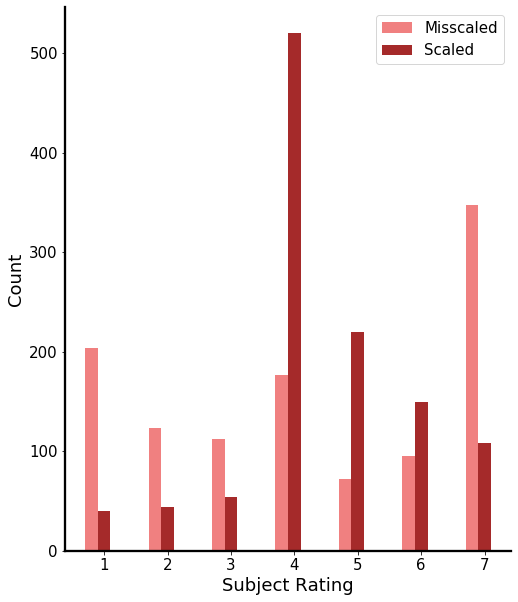

In [54]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

rating_ms =   [data_1_ms, data_2_ms, data_3_ms, data_4_ms, data_5_ms, data_6_ms, data_7_ms]

rating_s =   [data_1_s, data_2_s, data_3_s, data_4_s, data_5_s, data_6_s, data_7_s]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, rating_ms, width, color='lightcoral', label='Misscaled')
plt.bar(x, rating_s, width, color='brown', label='Scaled')
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')

plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

In [55]:
data_1_sm = len(data_1.loc[data_1['presentationSize']=='small']['accuracy'])
data_1_l = len(data_1.loc[data_1['presentationSize']=='large']['accuracy'])

data_2_sm = len(data_2.loc[data_2['presentationSize']=='small']['accuracy'])
data_2_l = len(data_2.loc[data_2['presentationSize']=='large']['accuracy'])

data_3_sm = len(data_3.loc[data_3['presentationSize']=='small']['accuracy'])
data_3_l = len(data_3.loc[data_3['presentationSize']=='large']['accuracy'])

data_4_sm = len(data_4.loc[data_4['presentationSize']=='small']['accuracy'])
data_4_l = len(data_4.loc[data_4['presentationSize']=='large']['accuracy'])

data_5_sm = len(data_5.loc[data_5['presentationSize']=='small']['accuracy'])
data_5_l = len(data_5.loc[data_5['presentationSize']=='large']['accuracy'])

data_6_sm = len(data_6.loc[data_6['presentationSize']=='small']['accuracy'])
data_6_l = len(data_6.loc[data_6['presentationSize']=='large']['accuracy'])

data_7_sm = len(data_7.loc[data_7['presentationSize']=='small']['accuracy'])
data_7_l = len(data_7.loc[data_7['presentationSize']=='large']['accuracy'])

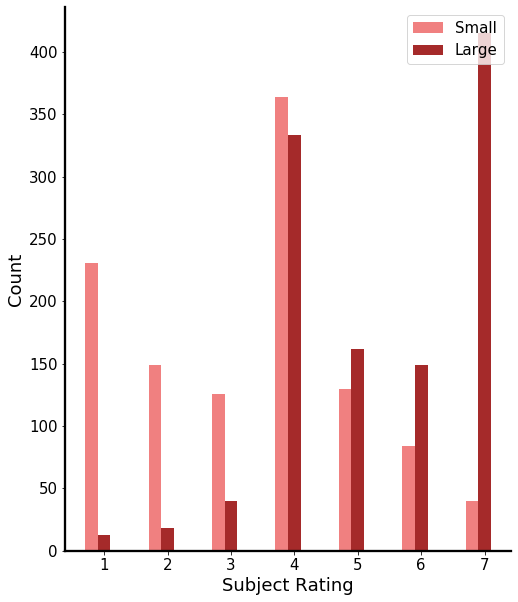

In [56]:
fig, ax = plt.subplots(figsize=[8,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
x = np.arange(7)

rating_sm =   [data_1_sm, data_2_sm, data_3_sm, data_4_sm, data_5_sm, data_6_sm, data_7_sm]

rating_l =   [data_1_l, data_2_l, data_3_l, data_4_l, data_5_l, data_6_s, data_7_l]

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, rating_sm, width, color='lightcoral', label='Small')
plt.bar(x, rating_l, width, color='brown', label='Large')
plt.xticks(x, [1, 2, 3, 4, 5, 6, 7], fontsize='15')

plt.yticks(fontsize=15) 
plt.xlabel("Subject Rating", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.legend(loc=1, fontsize=15)
plt.show()

## Demographics

In [251]:
ages = list(input_data['age'])

cleaned_ages = []
for age in ages:
    if age > 100:
        c_age = 2023-age
        cleaned_ages.append(c_age)
    else:
        cleaned_ages.append(age)

np.mean(np.array(cleaned_ages)), np.std(np.array(cleaned_ages))

(38.05263157894737, 11.342237553671456)

In [254]:
genders = input_data.gender.unique()
genders

array(['Man', 'Woman'], dtype=object)

In [256]:
women_df = final_data.loc[final_data['gender']=='Woman']
men_df = final_data.loc[final_data['gender']=='Man']


In [257]:
len(women_df.subjID.unique()), len(men_df.subjID.unique())

(50, 46)

## Time Spent

In [260]:
subjs = final_data.subjID.unique()
expTimes = []
for subj in subjs:
    subj_df = final_data.loc[final_data['subjID']==subj]
    expTime = subj_df.experimentTime.unique()[0]
    expTimes.append(expTime)

In [263]:
np.mean(np.array(expTimes))/60000, np.std(np.array(expTimes))/60000
# in minutes

(5.1683251736111115, 1.8482132044827804)